In [3]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [1]:
!ls /Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/

c_stayz_nsw_extract_2018-03-28.json   stayz_nsw_extract_2018-03-16.json.zip
find_brackets.sh                      stayz_nsw_extract_2018-03-17.json.zip
stayz_nsw_extract_2018-01-26.json.gz  stayz_nsw_extract_2018-03-18.json.zip
stayz_nsw_extract_2018-02-17.json.gz  stayz_nsw_extract_2018-03-19.json.zip
stayz_nsw_extract_2018-02-22.json.gz  stayz_nsw_extract_2018-03-20.json.zip
stayz_nsw_extract_2018-02-26.json.gz  stayz_nsw_extract_2018-03-21.json.zip
stayz_nsw_extract_2018-02-28.json.gz  stayz_nsw_extract_2018-03-22.json.zip
stayz_nsw_extract_2018-03-02.json.gz  stayz_nsw_extract_2018-03-23.json.zip
stayz_nsw_extract_2018-03-03.json.gz  stayz_nsw_extract_2018-03-24.json.zip
stayz_nsw_extract_2018-03-04.json.gz  stayz_nsw_extract_2018-03-25.json.zip
stayz_nsw_extract_2018-03-05.json.gz  stayz_nsw_extract_2018-03-26.json.zip
stayz_nsw_extract_2018-03-06.json.gz  stayz_nsw_extract_2018-03-27.json.zip
stayz_nsw_extract_2018-03-08.json.gz  stayz_nsw_extract_2018-03-28.json.zip
stayz_nsw_ex

In [3]:
#date_str = datetime.datetime.now().strftime("%Y-%m-%d")

date_str ='2018-03-22'

# Read the data file and display
nsw_data = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json.zip')

nsw_data = nsw_data.reset_index(drop=True)
nsw_data = nsw_data.set_index('property_id')

# If the initial price is zero, set to NaN so it doesnt affect the statistics
nsw_data.loc[nsw_data['init_price'] == 0,'init_price'] = np.nan

nsw_data.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9082944,2,3,7,"""The Best in Culburra "" Kate Nov 17",8,Escape@Culburra ABSOLUTE BEACH FRONT luxury be...,446.0,-34.933100,150.77500,House,174,2018-03-22 01:00:08,S,199,111,https://www.stayz.com.au//accommodation/nsw/so...
9140176,2,4,9,AWARDED AUSTRALIA'S TOP PET FRIENDLY RENTAL FO...,9,BLUE ISLAND - Award winning holiday home,242.0,-34.924686,150.76315,House,51,2018-03-22 01:00:08,S,200,110,https://www.stayz.com.au//accommodation/nsw/so...
9197130,3,3,3,Architecturally designed with bespoke interior...,6,140 Mitchell at Mollymook - Luxury Beach House,790.0,-35.324104,150.47970,House,22,2018-03-22 01:00:09,SW,203,161,https://www.stayz.com.au//accommodation/nsw/so...
9060297,2,2,2,La Petite Maison is perfectly stunning,4,La Petite Maison Leura- Blue Mountains,269.0,-33.714140,150.32840,Cottage,87,2018-03-22 01:00:09,W,291,84,https://www.stayz.com.au//accommodation/nsw/bl...
9132622,2,5,6,This is a cosy 4-5 bedroom cottage for $200/ni...,9,Millthorpe Cottage 18,204.0,-33.442738,149.18095,House,59,2018-03-22 01:00:09,W,287,194,https://www.stayz.com.au//accommodation/nsw/ex...


In [4]:
nsw_data.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,18157.000000,18157.000000,18157.000000,18157.000000,17915.000000,18157.000000,18157.000000,18157.000000,18157.000000,18157.000000
mean,1.852013,2.961502,4.278460,6.661508,313.021490,-33.180893,151.274946,5.675552,111.039985,226.119128
std,1.207840,1.610341,3.180739,3.860075,2349.784097,2.533160,4.566482,12.327407,107.070214,329.218611
min,0.000000,0.000000,0.000000,1.000000,1.000000,-41.453060,-100.945830,0.000000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,4.000000,141.000000,-34.795284,150.534000,0.000000,22.000000,81.000000
50%,2.000000,3.000000,4.000000,6.000000,208.000000,-33.605840,151.270000,1.000000,32.000000,163.000000
75%,2.000000,4.000000,5.000000,8.000000,330.000000,-32.340940,152.465270,5.000000,203.000000,341.000000
max,50.000000,50.000000,100.000000,120.000000,312197.000000,41.970135,167.949000,193.000000,359.000000,15713.000000


In [5]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_data.loc[nsw_data['guests'] <= 4]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Fileter for 4 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['beds'] <= 4 ]


nsw_data_s3.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9060297,2,2,2,La Petite Maison is perfectly stunning,4,La Petite Maison Leura- Blue Mountains,269.0,-33.71414,150.32840,Cottage,87,2018-03-22 01:00:09,W,291,84,https://www.stayz.com.au//accommodation/nsw/bl...
9026665,1,2,3,Modern spacious ground floor apartment set in ...,4,50 Metres to the Beach...Byron Bay,208.0,-28.64100,153.61000,Apartment,15,2018-03-22 01:00:09,N,21,638,https://www.stayz.com.au//accommodation/nsw/no...
9060812,2,2,3,Our 4 cottages are set in a glorious bushland ...,4,TOUCHDOWN COTTAGES JINDABYNE,128.0,-36.42840,148.60300,Cottage,45,2018-03-22 01:00:09,SW,220,358,https://www.stayz.com.au//accommodation/nsw/sn...
9069072,2,2,2,"Surrounded by national parkland, with its own ...",4,The Treehouse - Hawkesbury River. Tranquil wat...,260.0,-33.43125,151.05113,House,75,2018-03-22 01:00:10,N,349,63,https://www.stayz.com.au//accommodation/nsw/sy...
9208330,1,1,1,MID WEEK SPECIAL RATE - Minimum two nights. Th...,2,Mill Paddock - Romantic Getaway,214.0,-33.45062,150.60938,Cottage,12,2018-03-22 01:00:10,NW,318,79,https://www.stayz.com.au//accommodation/nsw/bl...


In [6]:
# Testing - look in detail at any outliers

t1 = nsw_data_s3.loc[nsw_data_s3['init_price'] == 2200]
t1.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
176951,2,3,3,"Contemporary Hotels presents, The Coogee. A th...",4,THE COOGEE,2200.0,-33.923473,151.24829,House,0,2018-03-22 01:08:36,NE,40,9,https://www.stayz.com.au//accommodation/nsw/sy...


In [7]:
nsw_data_s3.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,4852.000000,4852.000000,4852.000000,4852.000000,4766.000000,4852.000000,4852.000000,4852.000000,4852.000000,4852.000000
mean,1.188788,1.582028,2.050289,3.329555,185.825220,-33.032877,151.088440,5.588829,104.562242,229.448269
std,0.416885,0.544145,0.874491,0.905564,108.660453,3.067691,7.695531,11.854341,111.267231,520.299258
min,0.000000,0.000000,0.000000,1.000000,14.000000,-41.293920,-84.997270,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,122.000000,-34.278292,150.638745,0.000000,21.000000,39.000000
50%,1.000000,2.000000,2.000000,4.000000,168.000000,-33.722362,151.235840,1.000000,30.000000,135.000000
75%,1.000000,2.000000,3.000000,4.000000,224.000000,-32.180789,152.203390,5.000000,203.000000,348.000000
max,4.000000,5.000000,4.000000,4.000000,2200.000000,39.079407,153.635880,149.000000,359.000000,15713.000000


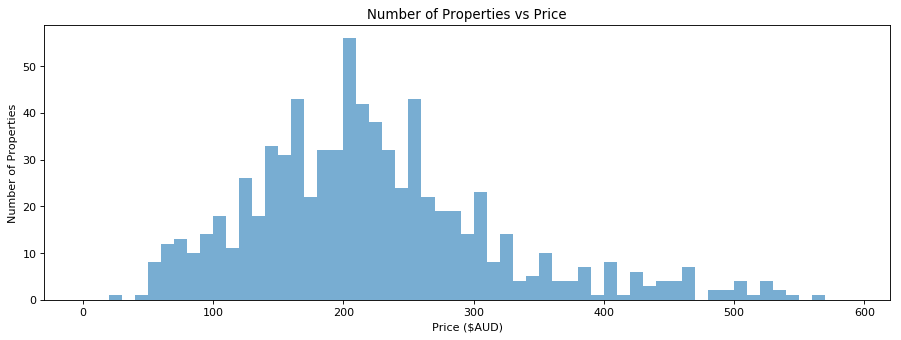

In [35]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=600, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')



# Filter to only 2 bedroom units:
tran_small_price1 = nsw_data_s3.loc[nsw_data_s3['bedrooms'] == 2]

# Filter where distance to Sydney between 100-150km
tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_dist_km'] >= 100) & (tran_small_price1['syd_dist_km'] <= 150)]

tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_brg'] == 'N')]


x = tran_small_price_local['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

In [9]:
tran_small_price_local.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,795.000000,795.0,795.000000,795.000000,778.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,1.421384,2.0,2.489308,3.924528,232.047558,-31.862264,152.036990,4.748428,42.763522,250.784906
std,0.533319,0.0,0.594538,0.328096,127.479240,2.350784,1.066095,11.518340,91.488018,279.514135
min,1.000000,2.0,0.000000,2.000000,23.000000,-33.908756,150.885570,0.000000,0.000000,9.000000
25%,1.000000,2.0,2.000000,4.000000,158.000000,-33.826380,151.220645,0.000000,13.000000,18.000000
50%,1.000000,2.0,2.000000,4.000000,213.500000,-33.437096,151.334930,0.000000,19.000000,65.000000
75%,2.000000,2.0,3.000000,4.000000,270.750000,-28.788037,153.510265,4.000000,21.000000,621.500000
max,3.000000,2.0,4.000000,4.000000,1375.000000,-27.484535,153.635440,126.000000,359.000000,744.000000


Text(0,0.5,'Count')

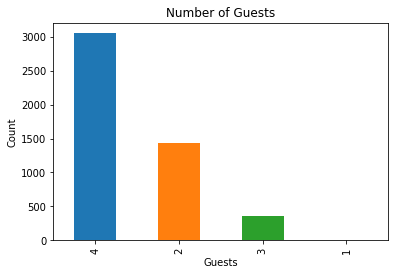

In [10]:
nsw_data_s3['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [11]:
nsw_data_s3['guests'].groupby(nsw_data_s3['guests']).count()

guests
1       4
2    1441
3     359
4    3048
Name: guests, dtype: int64

In [12]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': nsw_data_s3['init_price'],
    'Type': nsw_data_s3['property_type'],
    'Bathrooms' : nsw_data_s3['bathrooms'],
    'Beds' : nsw_data_s3['beds']
})

#train_display.groupby('Type').hist()

Geocoded Data

In [13]:
# Read the data file and display
geodata = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_full.json')

geodata = geodata.reset_index(drop=True)
geodata = geodata.set_index('property_id')

geodata.head()


,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,
9082944,Shoalhaven,"180-182 Penguins Head Rd, Culburra Beach NSW 2...",2540,Penguins Head Rd,180-182,NSW,Culburra Beach
9024318,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia
9024954,Sutherland Shire,"18 The Lambeth Walk, Bundeena NSW 2230, Australia",2230,The Lambeth Walk,18,NSW,Bundeena
9140176,Shoalhaven,"136 Prince Edward Ave, Culburra Beach NSW 2540...",2540,Prince Edward Ave,136,NSW,Culburra Beach
9026665,Byron,"13 Shirley St, Byron Bay NSW 2481, Australia",2481,Shirley St,13,NSW,Byron Bay


In [14]:
# Merge the nsw_extract with the geocoded data:
full_dataset = nsw_data.merge(geodata, how='inner', left_index=True, right_index=True)

full_dataset.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_brg_deg,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,,,,,,,,,,,,,,,
9082944,2,3,7,"""The Best in Culburra "" Kate Nov 17",8,Escape@Culburra ABSOLUTE BEACH FRONT luxury be...,446.0,-34.933100,150.77500,House,...,199,111,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"180-182 Penguins Head Rd, Culburra Beach NSW 2...",2540,Penguins Head Rd,180-182,NSW,Culburra Beach
9140176,2,4,9,AWARDED AUSTRALIA'S TOP PET FRIENDLY RENTAL FO...,9,BLUE ISLAND - Award winning holiday home,242.0,-34.924686,150.76315,House,...,200,110,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"136 Prince Edward Ave, Culburra Beach NSW 2540...",2540,Prince Edward Ave,136,NSW,Culburra Beach
9060297,2,2,2,La Petite Maison is perfectly stunning,4,La Petite Maison Leura- Blue Mountains,269.0,-33.714140,150.32840,Cottage,...,291,84,https://www.stayz.com.au//accommodation/nsw/bl...,Blue Mountains,"105 Megalong St, Leura NSW 2780, Australia",2780,Megalong St,105,NSW,Leura
9026665,1,2,3,Modern spacious ground floor apartment set in ...,4,50 Metres to the Beach...Byron Bay,208.0,-28.641000,153.61000,Apartment,...,21,638,https://www.stayz.com.au//accommodation/nsw/no...,Byron,"13 Shirley St, Byron Bay NSW 2481, Australia",2481,Shirley St,13,NSW,Byron Bay
9024318,3,7,11,Welcome to Orion's Lookout: Luxury accom in Je...,16,Orion's Lookout Jervis Bay,727.0,-35.071800,150.68400,House,...,200,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia


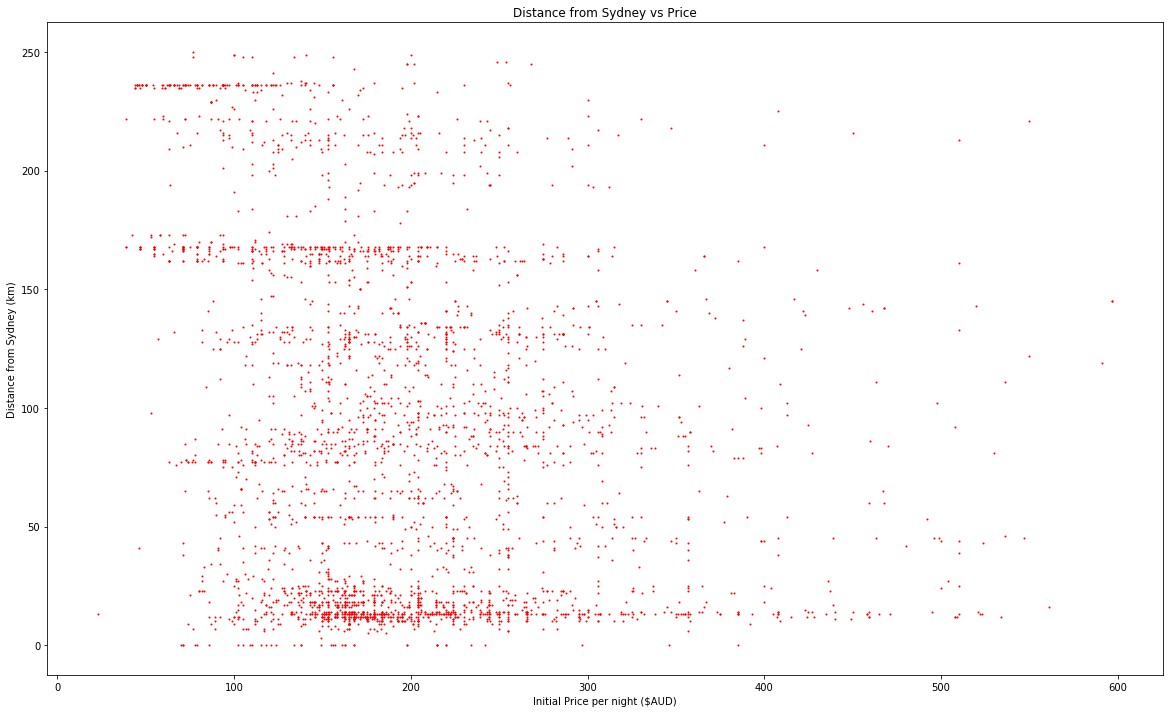

In [15]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))


nsw_data_s4 = nsw_data_s3[nsw_data_s3['syd_dist_km'] <= 250]

nsw_data_s5 = nsw_data_s4[nsw_data_s4['init_price'] <= 600]

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(nsw_data_s5['init_price'],nsw_data_s5['syd_dist_km'], s=1, c='red')

plt.show()

In [35]:
# Now bring in the bookings details
# Read the bookings file
bk_date_str = '2018-04-03'

b = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json'
                ,convert_dates=['arr_dt','dep_dt'])

# Change the index to property id
b.set_index('property_id',inplace=True)

# Sort the dataset so that all property id bookings are together
b2 = b.sort_index()


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
b2['book_type'] = b2['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

b3 = b2[b2['book_type'] == 'Cust']

b3.tail(5)

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9228676,2018-05-04,2,2018-05-07,Cust
9228676,2018-05-11,2,2018-05-14,Cust
9228676,2018-05-18,2,2018-05-21,Cust
9228676,2018-06-08,2,2018-06-11,Cust
9228676,2018-06-22,4,2018-06-27,Cust


In [36]:
# Check a specific record to make sure the bookings are calculated correctly
a = b3.loc[9228503]
a.sort_values(by=['arr_dt'])

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9228503,2018-04-04,5,2018-04-10,Cust
9228503,2018-04-12,3,2018-04-16,Cust
9228503,2018-04-18,11,2018-04-30,Cust
9228503,2018-05-01,5,2018-05-07,Cust
9228503,2018-05-18,3,2018-05-22,Cust
9228503,2018-05-23,4,2018-05-28,Cust
9228503,2018-06-08,2,2018-06-11,Cust
9228503,2018-07-12,3,2018-07-16,Cust
9228503,2018-07-19,3,2018-07-23,Cust


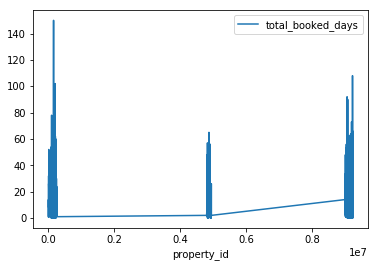

In [37]:
# Do a scatter plot of distance from sydney vs bookings count???

# Distance vs revenue?
# Distance vs revenue per person (assuming full occupancy)

# Percentage occupancy for the month vs distance
# 30/60/90 day occupancy vs distance (forward bookings)
# Las 30/60/90 day actual occupance vs distance (history bookings)

# Calculate the number of booked days for the 'Cust' type of bookings since b3 is the customers exc hosts
b5 = b3.groupby(['property_id']).sum()

# Rename the column as total_booked_days
b5.columns = ['total_booked_days']

b6 = b3.merge(b5, left_index=True, right_index=True)

# Count how many places have zero bookings


b5.plot()

In [38]:
# Check a particular property
b4 = b3.loc[9227458]

b4.head(20)

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9227458,2018-04-06,2,2018-04-09,Cust
9227458,2018-04-12,1,2018-04-14,Cust
9227458,2018-04-27,4,2018-05-02,Cust
9227458,2018-05-19,0,2018-05-20,Cust


In [19]:
# Join the full dataset with the bookings:

full_bookings = full_dataset.merge(b5, left_index=True, right_index=True)

full_bookings.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
9140176,2,4,9,AWARDED AUSTRALIA'S TOP PET FRIENDLY RENTAL FO...,9,BLUE ISLAND - Award winning holiday home,242.0,-34.924686,150.76315,House,...,110,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"136 Prince Edward Ave, Culburra Beach NSW 2540...",2540,Prince Edward Ave,136,NSW,Culburra Beach,48
9026665,1,2,3,Modern spacious ground floor apartment set in ...,4,50 Metres to the Beach...Byron Bay,208.0,-28.641000,153.61000,Apartment,...,638,https://www.stayz.com.au//accommodation/nsw/no...,Byron,"13 Shirley St, Byron Bay NSW 2481, Australia",2481,Shirley St,13,NSW,Byron Bay,49
9024318,3,7,11,Welcome to Orion's Lookout: Luxury accom in Je...,16,Orion's Lookout Jervis Bay,727.0,-35.071800,150.68400,House,...,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia,37
9166132,3,5,6,"LOCATION, GRANDEUR, SPACIOUS, COMFORT & PRIVACY",10,CAWARRA ON THE PARK - HISTORIC ELEGANT HOME GR...,935.0,-32.590416,149.59006,House,...,214,https://www.stayz.com.au//accommodation/nsw/ex...,Mid-Western Regional,"27-29 Short St, Mudgee NSW 2850, Australia",2850,Short St,27-29,NSW,Mudgee,61
9060812,2,2,3,Our 4 cottages are set in a glorious bushland ...,4,TOUCHDOWN COTTAGES JINDABYNE,128.0,-36.428400,148.60300,Cottage,...,358,https://www.stayz.com.au//accommodation/nsw/sn...,Snowy River,"150 Barry Way, Jindabyne NSW 2627, Australia",2627,Barry Way,150,NSW,Jindabyne,93


In [20]:
no_bookings = full_bookings[full_bookings['total_booked_days'] <= 3]

no_bookings.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
9105102,1,4,6,Features:,9,Captain KingFish Cottage,206.0,-35.016600,150.82700,Cottage,...,118,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"15 Greenwell St, Currarong NSW 2540, Australia",2540,Greenwell St,15,NSW,Currarong,3
9068471,2,3,4,"The unit is ideally placed with ocean views, h...",7,"Terraces on Sea, Terrigal",331.0,-33.447600,151.44100,Apartment,...,64,https://www.stayz.com.au//accommodation/nsw/ce...,Gosford,"34 Campbell Cres, Terrigal NSW 2260, Australia",2260,Campbell Cres,34,NSW,Terrigal,3
9169271,2,3,5,Bawley Point is well known for its fabulous un...,8,Windreef at Bawley Point,282.0,-35.508020,150.39700,House,...,183,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"52-54 Tingira Dr, Bawley Point NSW 2539, Austr...",2539,Tingira Dr,52-54,NSW,Bawley Point,3
9186380,1,1,1,Our one-bedroom self-contained ‘nest’ is the p...,2,The Nest at Misty Valley Farm,160.0,-32.947395,151.49237,Cabin,...,119,https://www.stayz.com.au//accommodation/nsw/hu...,Cessnock,"144 Leiberts Ln, Brunkerville NSW 2323, Australia",2323,Leiberts Ln,144,NSW,Brunkerville,1
9187741,1,3,5,Nestled on 100 acres in the rolling hills of t...,8,Guneemooroo Cottage - peaceful setting near Mu...,416.0,-32.603150,149.52174,Cottage,...,218,https://www.stayz.com.au//accommodation/nsw/ex...,Mid-Western Regional,"241 Old Grattai Rd, Erudgere NSW 2850, Australia",2850,Old Grattai Rd,241,NSW,Erudgere,3


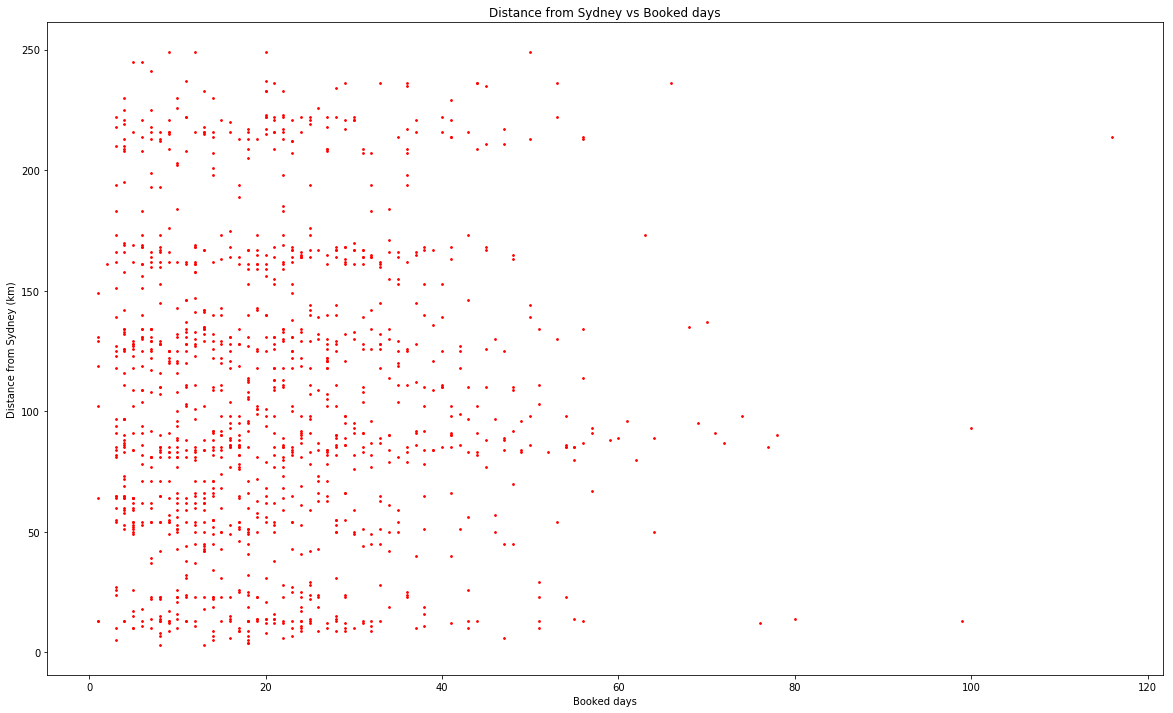

In [21]:
# Plot the distance vs booking days
plt.figure(figsize=(20,12))


nsw_data_s6 = full_bookings[full_bookings['syd_dist_km'] <= 250]

nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]





plt.title('Distance from Sydney vs Booked days')
plt.xlabel('Booked days')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(nsw_data_s7['total_booked_days'],nsw_data_s7['syd_dist_km'], s=3,c='red')

plt.show()

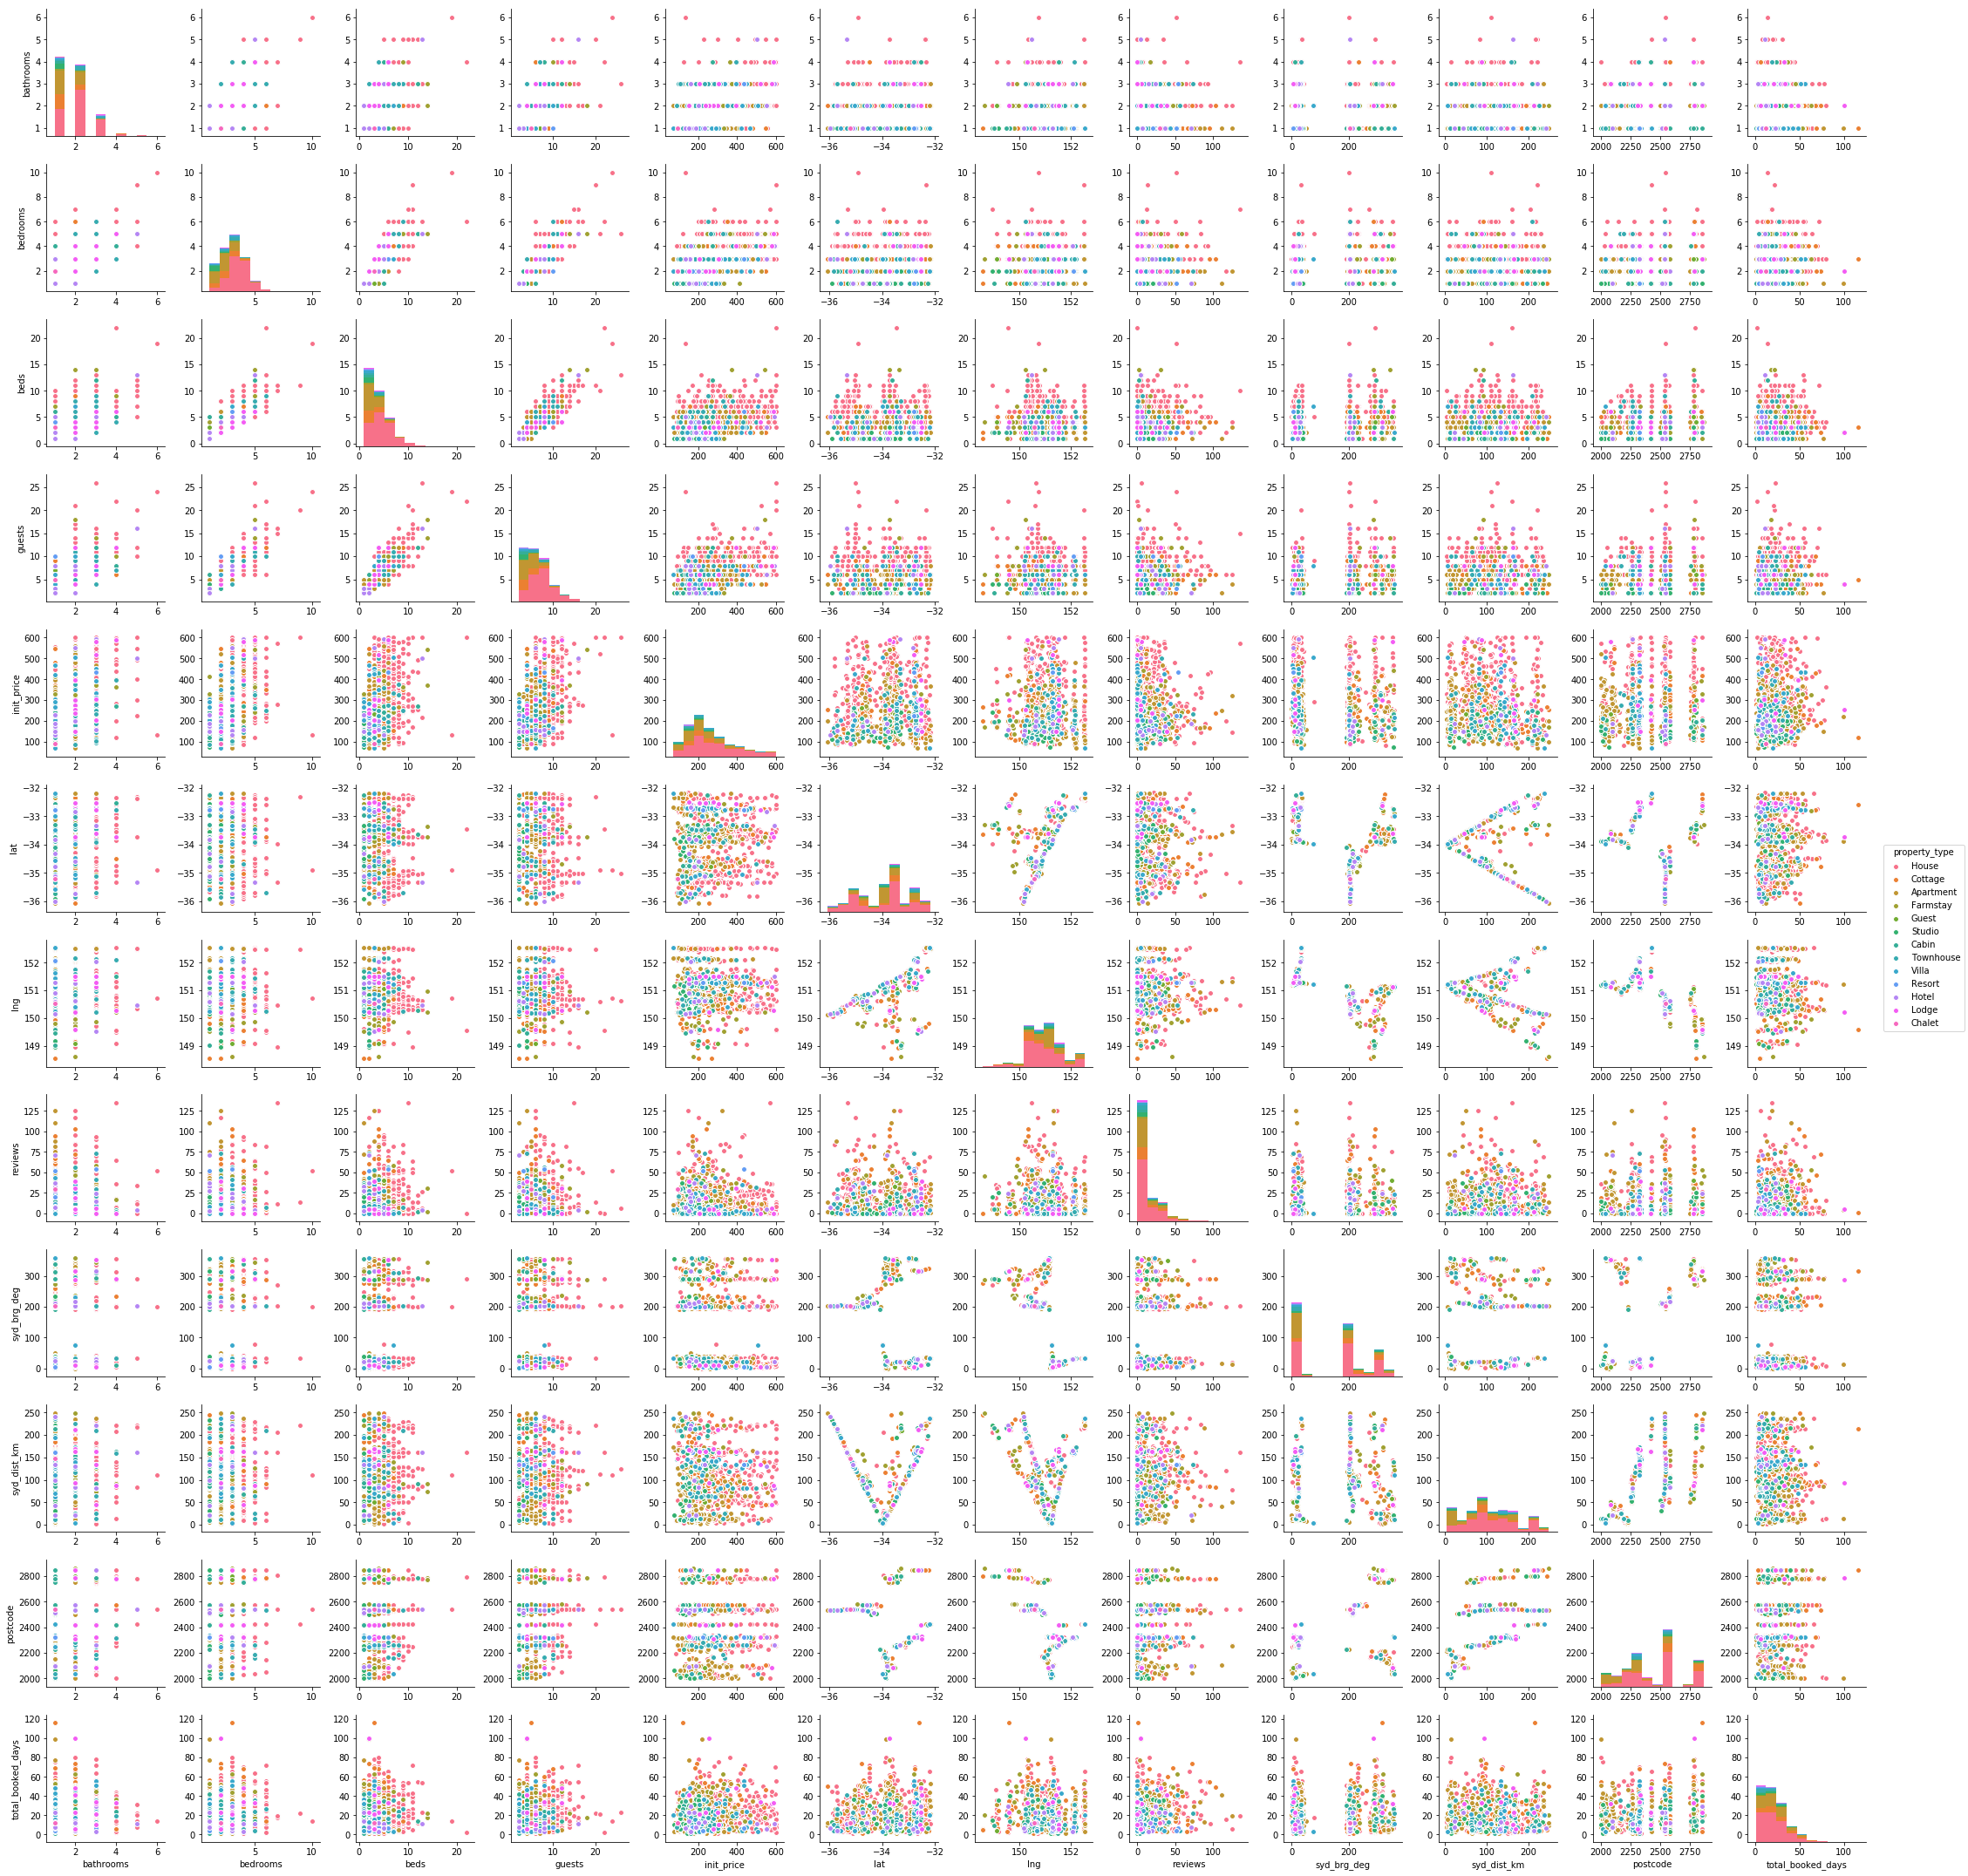

In [22]:
# Plot all variables with seaborn, coloured by property type
sns.pairplot(nsw_data_s7, hue="property_type")

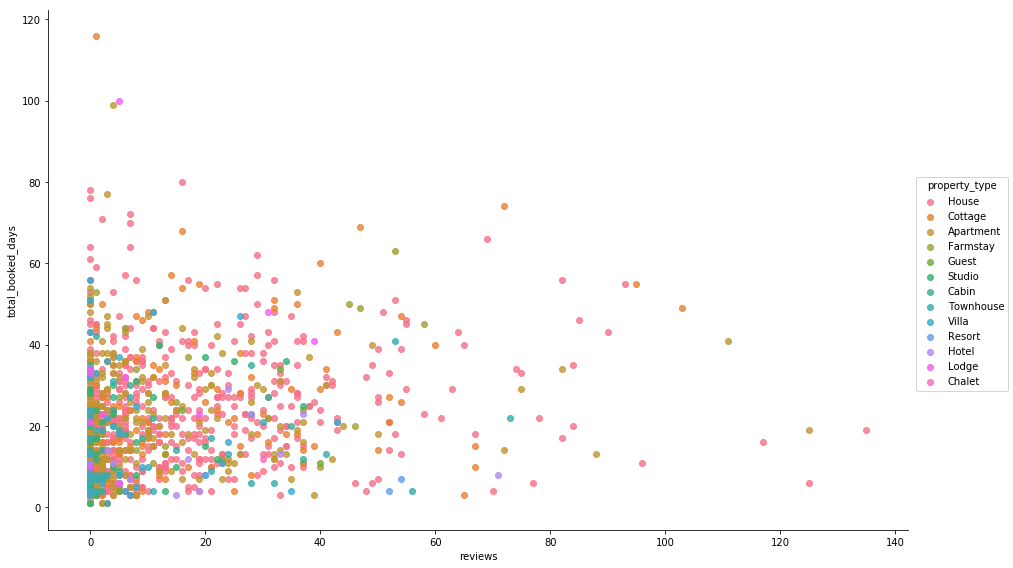

In [23]:
# Now check individual graphs in detail
sns.lmplot( x="reviews", y="total_booked_days", data=nsw_data_s7, fit_reg=False
           , hue='property_type'
           , aspect=1.61
          , size=8)


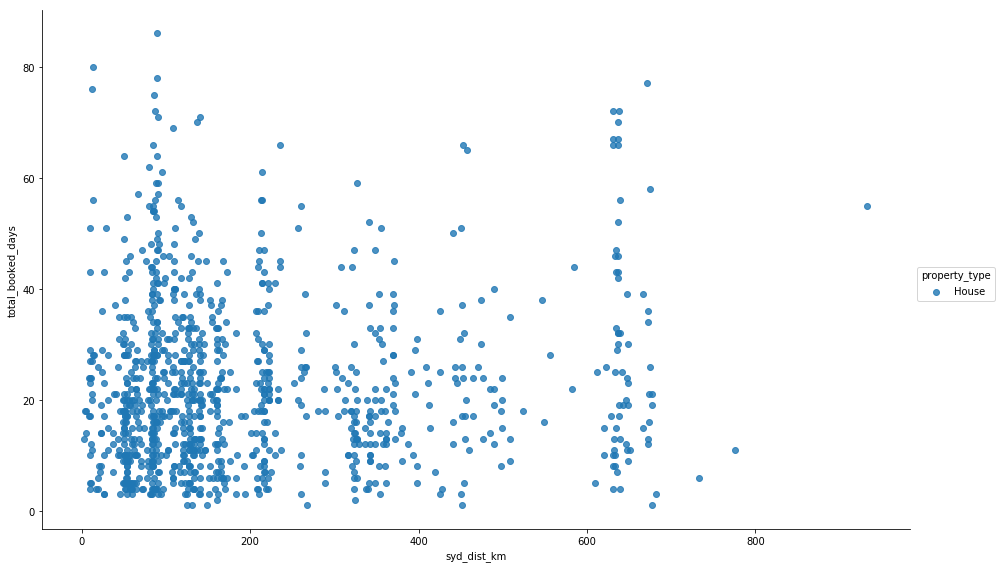

In [24]:
# Now check individual graphs in detail

# Try just one property_type

nsw_data_s8 = full_bookings[full_bookings['property_type'] == 'House']

sns.lmplot( x="syd_dist_km", y="total_booked_days", data=nsw_data_s8, fit_reg=False
           , hue='property_type'
           , aspect=1.61
          , size=8)

In [25]:
test_cor = full_bookings.corr(method='pearson')

test_cor

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km,postcode,total_booked_days
bathrooms,1.000000,0.704538,0.579942,0.688511,0.655172,0.043548,0.049341,0.009147,-0.046582,-0.006095,0.014830,0.132253
bedrooms,0.704538,1.000000,0.824101,0.876468,0.603020,-0.001108,-0.005142,0.004174,0.043991,-0.001088,0.108545,0.130191
beds,0.579942,0.824101,1.000000,0.877820,0.477505,-0.054462,-0.035638,0.050176,0.084485,-0.024799,0.123784,0.102137
guests,0.688511,0.876468,0.877820,1.000000,0.611490,-0.027291,-0.020643,0.022382,0.045601,-0.033563,0.087515,0.119699
init_price,0.655172,0.603020,0.477505,0.611490,1.000000,0.027890,0.018026,-0.031259,-0.060596,-0.124356,-0.062741,0.110947
lat,0.043548,-0.001108,-0.054462,-0.027291,0.027890,1.000000,0.769170,-0.035919,-0.540731,0.553943,-0.134514,0.097463
lng,0.049341,-0.005142,-0.035638,-0.020643,0.018026,0.769170,1.000000,-0.030683,-0.676641,0.264356,-0.413718,-0.001315
reviews,0.009147,0.004174,0.050176,0.022382,-0.031259,-0.035919,-0.030683,1.000000,0.082743,-0.045121,0.092146,0.210667
syd_brg_deg,-0.046582,0.043991,0.084485,0.045601,-0.060596,-0.540731,-0.676641,0.082743,1.000000,-0.204998,0.639659,0.054200
syd_dist_km,-0.006095,-0.001088,-0.024799,-0.033563,-0.124356,0.553943,0.264356,-0.045121,-0.204998,1.000000,0.298877,0.085167


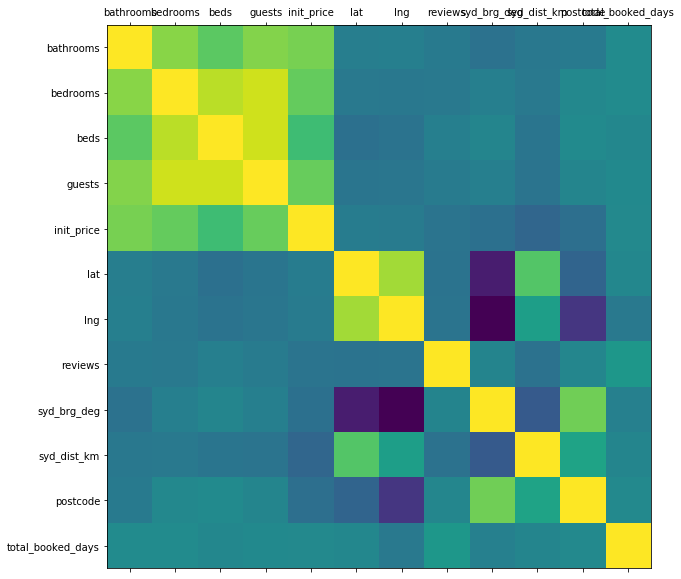

In [26]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(full_bookings)